In [ ]:
import sklearn.externals as extjoblib
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import KFold, cross_val_score

from dask.distributed import Client
import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import train_test_split
import mlxtend
from sklearn.linear_model import ElasticNet
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
import mlxtend
from sklearn.neighbors import KNeighborsRegressor
from random import sample

In [ ]:
independent = 'Poverty'
outer_k = 10
inner_k = 10
random_st = sample(list(np.arange(0,10,1)),1)[0]
print(random_st)

# configure the cross-validation procedure
cv_inner = KFold(n_splits=inner_k, shuffle=True, random_state=random_st)
cv_outer = KFold(n_splits=outer_k, shuffle=True, random_state=random_st+1)

C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\distributed\client.py:1265: VersionMismatchWarning: Mismatched versions found

+-------------+---------------+---------------+---------------+
| Package     | client        | scheduler     | workers       |
+-------------+---------------+---------------+---------------+
| dask        | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| distributed | 2022.01.1     | 2021.11.2     | 2021.11.2     |
| lz4         | 3.1.3         | 3.1.10        | 3.1.10        |
| python      | 3.9.7.final.0 | 3.9.9.final.0 | 3.9.9.final.0 |
| toolz       | 0.11.1        | 0.11.2        | 0.11.2        |
+-------------+---------------+---------------+---------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


outer_test_ix [23 37 42 44 47]
outer_test_ix [ 3  6  7 20 30]
outer_test_ix [ 2 10 32 39 40]
outer_test_ix [18 21 27 31 35]
outer_test_ix [ 1 12 26 34 45]
outer_test_ix [ 5 13 17 19 22]
outer_test_ix [ 4 14 24 33 41]
outer_test_ix [11 16 38 46 48]
outer_test_ix [ 8 25 29 43 49]
outer_test_ix [ 0  9 15 28 36]

outer cv abs error mean:  1.1334478106988723
outer cv abs error std:  0.6223275369651992
Final Model


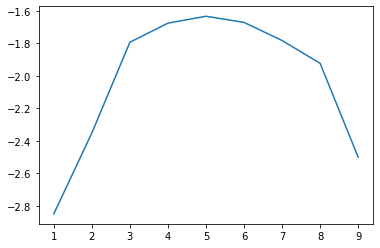

6 ('White', 'Doctors', 'Traf Deaths', 'Unemployed', 'Income', 'Population')
best_score -1.598500048991322
                            OLS Regression Results                            
Dep. Variable:                Poverty   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     50.53
Date:                Sat, 23 Jul 2022   Prob (F-statistic):           6.88e-18
Time:                        19:08:57   Log-Likelihood:                -72.203
No. Observations:                  50   AIC:                             158.4
Df Residuals:                      43   BIC:                             171.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
------------------------

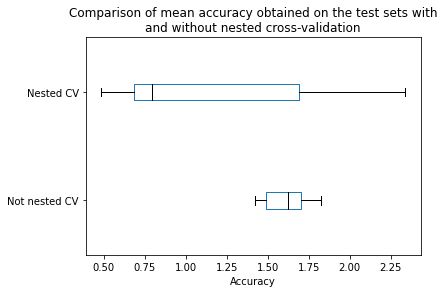

In [385]:
data = pd.read_csv('https://raw.githubusercontent.com/thistleknot/python-ml/master/data/raw/states.csv')
independent = 'Poverty'

y = data[[independent]]
X = data.loc[:, ~data.columns.isin([independent,'States'])].copy()

# configure the cross-validation procedure
outer_k = 10
inner_k = 10
random_st = sample(list(np.arange(0,10,1)),1)[0]
#print(random_st)

cv_inner = KFold(n_splits=inner_k, shuffle=True, random_state=random_st)
cv_outer = KFold(n_splits=outer_k, shuffle=True, random_state=random_st+1)

outer_results = []
client = Client('192.168.3.100:8786',timeout=3)

for outer_train_ix, outer_test_ix in cv_outer.split(X.index):

    inner_results = []

    for inner_train_ix, inner_test_ix in cv_inner.split(outer_train_ix):

        #print("inner_train_ix",inner_train_ix)
        #print("inner_test_ix",inner_test_ix)

        X_train_inner = X.iloc[inner_train_ix]
        X_test_inner = X.iloc[inner_test_ix]
        y_train_inner = y.iloc[inner_train_ix]
        y_test_inner = y.iloc[inner_test_ix]

        """
        # define search space
        space = dict()
        space['n_estimators'] = [10, 100, 500]
        space['max_features'] = [2, 4, 6]
        """

        lm = LinearRegression()

        sfs1 = SFS(estimator=lm, 
                   k_features=(1, len(X.columns)),
                   forward=True, 
                   floating=False, 
                   n_jobs=-1,
                   scoring='neg_mean_squared_error',
                   cv=cv_inner)         

        with joblib.parallel_backend('dask'):
            sfs1.fit(X_train_inner, y_train_inner)

        #plt.plot(pd.DataFrame(sfs1.get_metric_dict()).T['avg_score'])
        #plt.show()    

        best_features = pd.DataFrame(sfs1.get_metric_dict()).T['feature_names'].iloc[np.argmin(abs(pd.DataFrame(sfs1.get_metric_dict()).T['avg_score']))]
        #print(len(best_features),best_features)
        best_score = pd.DataFrame(sfs1.get_metric_dict()).T['avg_score'].iloc[np.argmin(abs(pd.DataFrame(sfs1.get_metric_dict()).T['avg_score']))]
        #print("best_score", best_score)

        inner_results.append([best_features,best_score])

    best_subset = pd.DataFrame(inner_results).iloc[:,0][np.argmin(pd.DataFrame(inner_results).iloc[:,1])]

    outer_model = LinearRegression()

    outer_model.fit(X.iloc[outer_train_ix], y.iloc[outer_train_ix])

    y_pred = outer_model.predict(X.iloc[outer_test_ix])

    outer_results.append(np.mean(abs(y_pred.ravel()-y.iloc[outer_test_ix].values.ravel())))
    #print("outer_train_ix",outer_train_ix)
    print("outer_test_ix",outer_test_ix)

#model that performed best on the outer (out of sample) forecasts is selected        2
print()
print("outer cv abs error mean: ",np.mean(outer_results))
print("outer cv abs error std: ",np.std(outer_results))

print("Final Model")
final_model = LinearRegression()

sfs2 = SFS(estimator=lm, 
           k_features=(1, len(X.columns)),
           forward=True, 
           floating=False, 
           n_jobs=-1,
           scoring='neg_mean_squared_error',
           cv=cv_outer)   

with joblib.parallel_backend('dask'):
    sfs2.fit(X,y)
    
plt.plot(pd.DataFrame(sfs1.get_metric_dict()).T['avg_score'])
plt.show()
best_features = pd.DataFrame(sfs2.get_metric_dict()).T['feature_names'].iloc[np.argmin(abs(pd.DataFrame(sfs2.get_metric_dict()).T['avg_score']))]
print(len(best_features),best_features)
best_score = pd.DataFrame(sfs2.get_metric_dict()).T['avg_score'].iloc[np.argmin(abs(pd.DataFrame(sfs2.get_metric_dict()).T['avg_score']))]
print("best_score", best_score)

import statsmodels.api as sm

#define response variable
#add constant to predictor variables
x = sm.add_constant(X[np.array(best_features)])

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

all_scores = {
    "Not nested CV": [abs(r[1]) for r in inner_results],
    "Nested CV": outer_results,
}
all_scores = pd.DataFrame(all_scores)

color = {"whiskers": "black", "medians": "black", "caps": "black"}
all_scores.plot.box(color=color, vert=False)
plt.xlabel("Accuracy")
_ = plt.title("Comparison of mean accuracy obtained on the test sets with\n"
              "and without nested cross-validation")